# Learning b-splines

Let us now firstly define the basic building blocks aka splines  

In [7]:
import numpy as np
import matplotlib.pyplot as plt

Knots: Shape: (10,), values: [-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]
x: Shape: (1000,), values: [-1.         -0.997998   -0.995996   -0.99399399 -0.99199199]
k=0, number of basis functions: 9
k=1, number of basis functions: 10
k=2, number of basis functions: 11
k=3, number of basis functions: 12


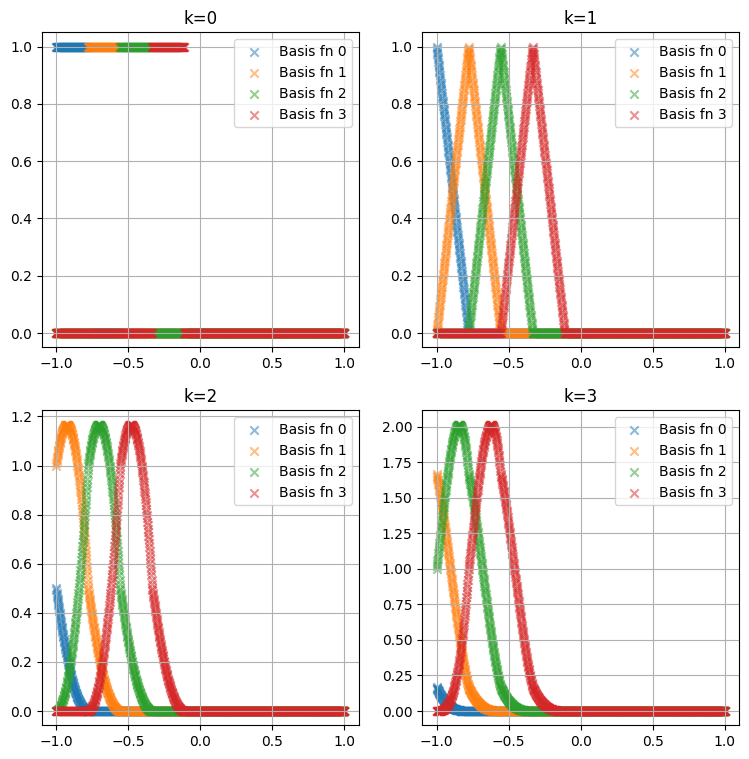

In [21]:
def extend_knots(knots, spline_order):
    """
    Extends the knots on either side by spline_order steps.

    Args:
        knots (numpy.ndarray): Array of control points of shape (number of control points,).
        spline_order (int): Spline order.

    Returns:
        numpy.ndarray: Extended knots of shape (number of control points + 2 * spline_order,).
    """
    n_intervals = knots.shape[-1] - 1
    bucket_size = (knots[-1] - knots[0]) / n_intervals

    for _ in range(spline_order):
        knots = np.concatenate(([knots[0] - bucket_size], knots))
        knots = np.concatenate((knots, [knots[-1] + bucket_size]))

    return knots

def evaluate_basis_functions(x_eval, knots, spline_order):
    """
    Evaluates basis functions for order-k splines with control points defined in knots.

    Args:
        x_eval (numpy.ndarray): Evaluation points of shape (number of samples,).
        knots (numpy.ndarray): Control points of shape (number of control points,).
        spline_order (int): Order of spline.

    Returns:
        numpy.ndarray: Basis function values of shape (number of samples, number of basis functions).
    """
    knots_ = extend_knots(knots, spline_order)
    knots_ = knots_[:, np.newaxis]  # Shape: (number of control points + 2 * spline_order, 1)
    x_ = x_eval[np.newaxis, :]      # Shape: (1, number of samples)

    for idx in range(spline_order + 1):
        if idx == 0:
            bases = ((x_ >= knots_[:-1]) & (x_ < knots_[1:])).astype(float)
        else:
            numerator1 = x_ - knots_[:-idx - 1]
            denominator1 = knots_[1:-idx] - knots_[:-idx - 1]
            factor1 = np.divide(numerator1, denominator1, out=np.zeros_like(numerator1), where=denominator1 != 0)
            bases1 = factor1 * bases[:-1]

            numerator2 = knots_[idx + 1:] - x_
            denominator2 = knots_[idx + 1:] - knots_[1:-idx]
            factor2 = np.divide(numerator2, denominator2, out=np.zeros_like(numerator2), where=denominator2 != 0)
            bases2 = factor2 * bases[1:]

            bases = bases1 + bases2

    bases = bases.T  # Shape: (number of samples, number of basis functions)
    return bases

# Define grid and evaluation points
knots = np.linspace(-1, 1, num=10)
x = np.linspace(-1, 1, num=1000)

print(f"Knots: Shape: {knots.shape}, values: {knots}")
print(f"x: Shape: {x.shape}, values: {x[:5]}")

# Evaluate basis functions for different spline orders
value1 = evaluate_basis_functions(x, knots, spline_order=0)
value2 = evaluate_basis_functions(x, knots, spline_order=1)
value3 = evaluate_basis_functions(x, knots, spline_order=2)
value4 = evaluate_basis_functions(x, knots, spline_order=3)

print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")

# Plotting the basis functions
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 9), dpi=100)

n_basis_to_plot = 4
all_basis = [(value1, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]

for i in range(4):
    ax = axs[i // 2, i % 2]
    value, label = all_basis[i]
    for idx in range(min(n_basis_to_plot, value.shape[1])):
        ax.scatter(x, value[:, idx], marker='x', label=f"Basis fn {idx}", alpha=0.5)
    ax.grid()
    ax.set_title(label)
    ax.legend()

plt.show()
